In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
######## FROM CLOSURE PARAMETERS TO JOINT CONFIGURATION #########

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import csv

In [7]:
from sklearn.preprocessing import StandardScaler

In [9]:
from sklearn.decomposition import PCA

In [3]:
dataset_path = '/content/drive/MyDrive/Medical_Robotics_Project/last_dataset.csv'

In [4]:
with open(dataset_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header row
    data = [row[:-4] for row in reader]  # Take all columns except last 3
joint_angles = np.array(data, dtype=float)

In [5]:
with open(dataset_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header row
    data = [row[-4:] for row in reader]  # Take all columns except last 3
closure_parameters = np.array(data, dtype=float)

In [15]:
# 1. Standardize
scaler = StandardScaler()
joint_angles_standardized = scaler.fit_transform(joint_angles)

# 2. PCA with 95% variance retention
pca = PCA(n_components=0.97)
synergy_matrix = pca.fit_transform(joint_angles_standardized)

print(f"Original dimensions: {joint_angles.shape[1]}")
print(f"Reduced dimensions: {synergy_matrix.shape[1]}")
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")

Original dimensions: 27
Reduced dimensions: 9
Explained variance: 0.98


In [ ]:
#Normalize
scaler_closures = MinMaxScaler()
scaler_joints = MinMaxScaler()
X_scaled = scaler_closures.fit_transform(closure_parameters)
y_scaled = scaler_joints.fit_transform(joint_angles)

In [ ]:
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)
#dataset = TensorDataset(X_tensor, y_tensor)
#loader = DataLoader(dataset, batch_size=32, shuffle=True)

Epoch 0: Train Loss = 70.4856, Val Loss = 21.1738
Epoch 10: Train Loss = 22.2568, Val Loss = 6.7028
Epoch 20: Train Loss = 7.7317, Val Loss = 2.4836
Epoch 30: Train Loss = 3.9540, Val Loss = 1.4145
Epoch 40: Train Loss = 2.9603, Val Loss = 1.0842
Epoch 50: Train Loss = 1.9577, Val Loss = 0.7460
Epoch 60: Train Loss = 1.3661, Val Loss = 0.5425
Epoch 70: Train Loss = 1.0410, Val Loss = 0.4299
Epoch 80: Train Loss = 0.8181, Val Loss = 0.3558
Epoch 90: Train Loss = 0.6609, Val Loss = 0.3036
Epoch 100: Train Loss = 0.5550, Val Loss = 0.2687
Epoch 110: Train Loss = 0.4826, Val Loss = 0.2454
Epoch 120: Train Loss = 0.4341, Val Loss = 0.2293
Epoch 130: Train Loss = 0.3977, Val Loss = 0.2186
Epoch 140: Train Loss = 0.3682, Val Loss = 0.2089
Epoch 150: Train Loss = 0.3434, Val Loss = 0.2009
Epoch 160: Train Loss = 0.3227, Val Loss = 0.1939
Epoch 170: Train Loss = 0.3045, Val Loss = 0.1880
Epoch 180: Train Loss = 0.2894, Val Loss = 0.1833
Epoch 190: Train Loss = 0.2762, Val Loss = 0.1792
Epoch 20

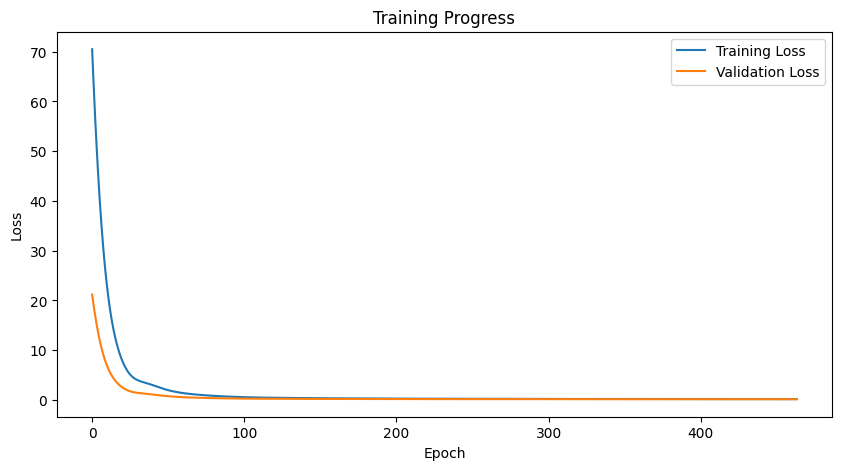


Prediction for [0.5, 0.2, 0.3]:
[-23.395874 -96.15837  -33.556187   8.040075  65.07215 ] ...


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#Train/Validation/Test Split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test)

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(3, 64)
        self.fc_mean = nn.Linear(64, 8)
        self.fc_logvar = nn.Linear(64, 8)
        # Decoder
        self.fc2 = nn.Linear(8, 64)
        self.fc3 = nn.Linear(64, 27)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mean(h), self.fc_logvar(h)

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = z_mean + torch.exp(0.5 * z_logvar) * torch.randn_like(z_logvar)
        return self.decode(z), z_mean, z_logvar

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
def loss_function(recon_y, y, z_mean, z_logvar):
    MSE = nn.MSELoss()(recon_y, y)
    KLD = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return MSE + 0.1 * KLD  # KL weight=0.1

# Training with early stopping
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(500):
    # Training
    model.train()
    optimizer.zero_grad()
    recon_y, z_mean, z_logvar = model(X_train_t)
    loss = loss_function(recon_y, y_train_t, z_mean, z_logvar)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        recon_val, z_mean_val, z_logvar_val = model(X_val_t)
        val_loss = loss_function(recon_val, y_val_t, z_mean_val, z_logvar_val)
        val_losses.append(val_loss.item())

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_vae.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch}!")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

# Load best model
model.load_state_dict(torch.load('best_vae.pth'))

# Test evaluation
model.eval()
with torch.no_grad():
    recon_test, _, _ = model(X_test_t)
    test_loss = loss_function(recon_test, y_test_t, _, _)
    print(f"\nFinal Test Loss: {test_loss.item():.4f}")

    # Compare first test sample
    sample_idx = 0
    pred = scaler_joints.inverse_transform(recon_test[sample_idx].numpy().reshape(1, -1))
    true = scaler_joints.inverse_transform(y_test[sample_idx].reshape(1, -1))
    print("\nTest Sample Comparison (first 5 values):")
    print("Predicted:", pred[0][:5])
    print("Actual:   ", true[0][:5])

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.show()

# Prediction function
def predict_joint_angles(thumb, index, middle):
    closure = np.array([[thumb, index, middle]])
    closure_scaled = scaler_closures.transform(closure)
    with torch.no_grad():
        recon = model(torch.FloatTensor(closure_scaled))[0]
    return scaler_joints.inverse_transform(recon.numpy())[0]

# Example usage
print("\nPrediction for [0.5, 0.2, 0.3]:")
print(predict_joint_angles(0.5, 0.2, 0.3)[:5], "...")  # First 5 angles

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CVAE model
class ConditionalVAE(nn.Module):
    def __init__(self, joint_dim=27, cond_dim=3, latent_dim=16, hidden_dim=64):
        """
        joint_dim: dimensionality of joint configuration (27)
        cond_dim: dimensionality of condition (closure parameters) (3)
        latent_dim: dimensionality of latent space
        hidden_dim: hidden layer size in encoder/decoder
        """
        super(ConditionalVAE, self).__init__()
        self.joint_dim = joint_dim
        self.cond_dim = cond_dim
        self.latent_dim = latent_dim

        # Encoder: input = joint configuration + condition
        self.encoder = nn.Sequential(
            nn.Linear(joint_dim + cond_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # Layers to output latent mean and log variance
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: input = latent variable + condition
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, joint_dim)
            # If you prefer, you can add a final activation (e.g., tanh or sigmoid)
            # depending on the expected range of joint positions.
        )

    def encode(self, x, c):
        # x: joint configuration [batch_size, joint_dim]
        # c: condition (closure parameters) [batch_size, cond_dim]
        xc = torch.cat([x, c], dim=1)
        h = self.encoder(xc)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # sample from standard normal
        return mu + eps * std

    def decode(self, z, c):
        # z: latent variable [batch_size, latent_dim]
        # c: condition (closure parameters) [batch_size, cond_dim]
        zc = torch.cat([z, c], dim=1)
        return self.decoder(zc)

    def forward(self, x, c):
        # Encode
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        # Decode
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

# Loss function (MSE + KL divergence)
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (Mean Squared Error)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    # See Kingma & Welling (2013) for the derivation
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Hyperparameters
joint_dim = 27
cond_dim = 3
latent_dim = 16
hidden_dim = 64
lr = 1e-3
epochs = 100
batch_size = 32

# Initialize the model, optimizer
model = ConditionalVAE(joint_dim=joint_dim, cond_dim=cond_dim,
                       latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Dummy dataset loading
# Assume you have your data in a CSV or similar
# For this example, we'll create dummy data.
# X_joint: [N, 27] joint configurations
# X_cond: [N, 3] closure parameters (the last 3 columns)
#N = 3487
#data = torch.randn(N, joint_dim + cond_dim)  # Replace this with your actual data
closure_tensor = torch.tensor(closure_parameters, dtype=torch.float32)
joint_tensor = torch.tensor(joint_angles, dtype=torch.float32)

# Split into joint config and conditions
#X_joint = data[:, :joint_dim]
#X_cond = data[:, joint_dim:]

# Create a simple DataLoader
dataset = torch.utils.data.TensorDataset(joint_tensor, closure_tensor )
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x_joint_batch, x_cond_batch in dataloader:
        x_joint_batch = x_joint_batch.to(device)
        x_cond_batch = x_cond_batch.to(device)

        optimizer.zero_grad()
        recon_joint, mu, logvar = model(x_joint_batch, x_cond_batch)
        loss = loss_function(recon_joint, x_joint_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataset)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# After training, you can predict/generate joint configuration from closure parameters only.
# For example, given a set of closure parameters, you can sample from the latent space
# (or use the prior mean=0) and decode:
model.eval()
with torch.no_grad():
    # Suppose we have a new set of closure parameters:
    new_closure = torch.tensor([[0.5, 0.5, 0.5]], device=device)  # shape [1, 3]
    # Sample a latent variable from standard normal:
    z_sample = torch.randn(1, latent_dim, device=device)
    predicted_joint = model.decode(z_sample, new_closure)
    print("Predicted joint configuration:", predicted_joint.cpu().numpy())


Epoch [10/100], Loss: 10487.3938
Epoch [20/100], Loss: 3577.5126
Epoch [30/100], Loss: 2219.2712
Epoch [40/100], Loss: 1425.6143
Epoch [50/100], Loss: 1144.9230
Epoch [60/100], Loss: 981.7871
Epoch [70/100], Loss: 842.9609


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(closure_parameters, joint_angles, test_size=0.2, random_state=42)

# Standardize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Latent space
        self.mu = nn.Linear(64, latent_dim)  # Mean of latent distribution
        self.log_var = nn.Linear(64, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Standard deviation
        eps = torch.randn_like(std)  # Sample noise
        return mu + eps * std  # Reparameterized sample

    def forward(self, x):
        encoded = self.encoder(x)
        mu, log_var = self.mu(encoded), self.log_var(encoded)
        z = self.reparameterize(mu, log_var)  # Sample from latent space
        decoded = self.decoder(z)  # Predict joint angles
        return decoded, mu, log_var

# Model initialization
input_dim = X_train.shape[1]
latent_dim = 10  # Size of the latent space (tuneable)
output_dim = y_train.shape[1]
vae = VAE(input_dim, latent_dim, output_dim)

# Loss function: MSE + KL Divergence
def vae_loss(y_pred, y_true, mu, log_var):
    reconstruction_loss = nn.MSELoss()(y_pred, y_true)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # Regularization
    return reconstruction_loss + kl_divergence * 1e-3  # Small weight for KL loss

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop
epochs = 500
for epoch in range(epochs):
    vae.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred, mu, log_var = vae(batch_X)
        loss = vae_loss(y_pred, batch_y, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {running_loss / len(train_loader):.6f}")

# Evaluate on test set
vae.eval()
with torch.no_grad():
    y_pred, _, _ = vae(X_test)
    test_mae = torch.mean(torch.abs(y_pred - y_test)).item()

print(f"Mean Absolute Error on Test Set: {test_mae:.6f}")

# Print some test samples
for i in range(5):
    print(f"Test Sample {i+1}")
    print("Actual:", y_test[i].numpy())
    print("Predicted:", y_pred[i].numpy())
    print("-" * 50)


Epoch 0/500, Loss: 7045.328136
Epoch 50/500, Loss: 1371.704268
Epoch 100/500, Loss: 1250.058046
Epoch 150/500, Loss: 1216.708610
Epoch 200/500, Loss: 1198.867622
Epoch 250/500, Loss: 1174.507944
Epoch 300/500, Loss: 1161.238735
Epoch 350/500, Loss: 1151.247455
Epoch 400/500, Loss: 1137.254013
Epoch 450/500, Loss: 1127.648578
Mean Absolute Error on Test Set: 10.920850
Test Sample 1
Actual: [ -23.8808   -147.7273    -30.56149    -2.043335 -159.9469    -22.69528
    8.176638 -163.7588    -19.35907    36.03012   -86.2417     -6.025177
   75.31094   -93.28214    -8.980255   63.06544    94.03695  -177.9341
   40.88224   -77.13181     4.979383   85.06501    11.51526    93.15002
   35.57439    93.31546   173.5354  ]
Predicted: [ -29.199335   -42.073895   -27.160711   -10.038341   -38.66503
  -18.452808    -1.7285691  -68.50235    -14.872401    35.759796
  -79.472885    -5.3617053   73.4911     -87.82688    -11.54158
   64.24836     86.72653   -163.38269     36.433483   -71.32751
    3.0152361 

In [ ]:
# Example usage
print("\nPrediction for [0.5, 0.2, 0.3]:")
print(predict_joint_angles(0.64, 0.53, 0.85), "...")  # First 5 angles


Prediction for [0.5, 0.2, 0.3]:
[ -22.991571   -98.37685    -33.530678     7.4693217   69.27075
  -28.3136      21.733791    68.98042    -35.185658    48.230095
  -87.50157     -5.611447    31.68982     18.234537  -107.938484
  -14.872257    31.610498  -115.779686    44.142944   -71.312996
   10.397556    30.637436    26.947237   101.41669    -15.682843
  -12.095941    78.45353  ] ...


In [ ]:
-45.93796,145.0146,-28.78024,-12.06824,129.0814,-15.38309,8.699547,124.5479,-11.68567,46.43133,-87.20255,-5.386444,79.02915,102.0949,-172.1305,25.31791,91.6809,-178.1561,69.24675,-67.51874,13.76224,26.70352,95.25876,174.0095,-65.1427,106.5657,169.6251

In [ ]:
from sklearn.preprocessing import StandardScaler

Epoch 0: Train Loss = 93.2°, Val Loss = 88.7°
Epoch 10: Train Loss = 75.8°, Val Loss = 72.9°
Epoch 20: Train Loss = 47.6°, Val Loss = 43.9°
Epoch 30: Train Loss = 35.1°, Val Loss = 34.5°
Epoch 40: Train Loss = 33.1°, Val Loss = 32.8°
Epoch 50: Train Loss = 32.8°, Val Loss = 32.7°
Epoch 60: Train Loss = 32.8°, Val Loss = 32.6°
Epoch 70: Train Loss = 32.7°, Val Loss = 32.6°
Early stopping at epoch 75!

Test Mean Angular Error: 32.8°

Test Sample Comparison:
Predicted: [[-135.   -45.   135.    45.   -45.  -135.    45.2 -135.   135.   135.1
    45.    44.9 -134.9   45.   -44.8  135.1   45.   -45.1   45.    45.1
  -135.    45.   -45.    45.    45.   -44.5  -45. ]]
Actual:    [[-125.8  -52.8  154.7   52.9  -33.8  -94.3    5.1 -179.8  131.   130.5
    76.2   84.7 -134.2   23.3  -49.9  137.    53.3  -47.1   91.8   45.
  -179.4    8.4  -74.5   31.2   97.4  -80.3  -17.6]]


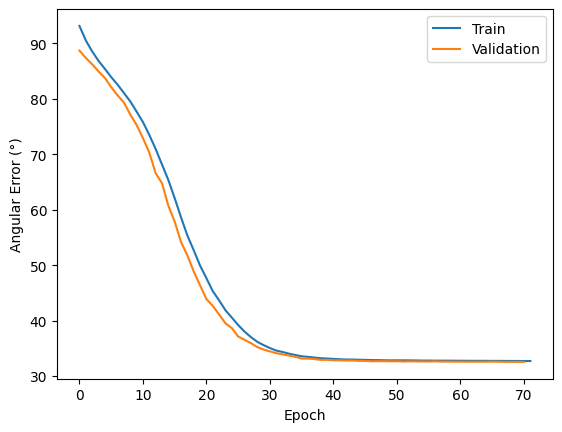


Prediction for [0.5, 0.2, 0.3]:
[-135.1  -45.   135.    45.   -45.2]


In [ ]:
# Specialized scaling for angles
def scale_angles(angles):
    """Convert angles to sin/cos representation"""
    return np.column_stack([np.sin(np.radians(angles)),
                          np.cos(np.radians(angles))]).reshape(angles.shape[0], -1)

y_scaled = scale_angles(joint_angles)  # Now shape (n_samples, 54) [sin+cos for each angle]
scaler_X = StandardScaler().fit(closure_parameters)
X_scaled = scaler_X.transform(closure_parameters)

# 80/10/10 Split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

# Improved VAE Architecture
class AngleVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mean = nn.Linear(64, 8)
        self.fc_logvar = nn.Linear(64, 8)

        # Decoder (outputs sin/cos pairs)
        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 54),  # 27 angles * [sin,cos]
            nn.Tanh()  # Constrain to [-1,1] for valid sin/cos
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mean(h), self.fc_logvar(h)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = z_mean + torch.exp(0.5 * z_logvar) * torch.randn_like(z_logvar)
        return self.decode(z), z_mean, z_logvar

model = AngleVAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Angular-aware loss
def angular_loss(pred_sincos, true_sincos):
    """Compute mean angular error in degrees"""
    pred_sin, pred_cos = pred_sincos[:,::2], pred_sincos[:,1::2]
    true_sin, true_cos = true_sincos[:,::2], true_sincos[:,1::2]

    # Calculate angular difference
    dot = pred_cos*true_cos + pred_sin*true_sin
    angle_diff = torch.acos(torch.clamp(dot, -1, 1))  # in radians
    return torch.mean(angle_diff) * 180 / np.pi  # convert to degrees

def loss_function(recon_y, y, z_mean, z_logvar):
    recon_loss = angular_loss(recon_y, y)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + 0.01 * kl_loss  # Reduced KL weight

# Training with early stopping
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(300):
    # Training
    model.train()
    optimizer.zero_grad()
    recon_y, z_mean, z_logvar = model(X_train_t)
    loss = loss_function(recon_y, y_train_t, z_mean, z_logvar)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        recon_val, z_mean_val, z_logvar_val = model(X_val_t)
        val_loss = loss_function(recon_val, y_val_t, z_mean_val, z_logvar_val)
        val_losses.append(val_loss.item())

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_vae.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch}!")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.1f}°, Val Loss = {val_loss.item():.1f}°")

# Load best model
model.load_state_dict(torch.load('best_vae.pth'))

# Convert sin/cos back to angles
def sincos_to_angles(sincos):
    """Convert [sin,cos] pairs back to degrees"""
    sincos = sincos.reshape(-1, 2)
    angles = np.degrees(np.arctan2(sincos[:,0], sincos[:,1]))
    return angles.reshape(-1, 27)  # Original shape

# Test evaluation
model.eval()
with torch.no_grad():
    recon_test, _, _ = model(torch.FloatTensor(X_test))
    test_loss = angular_loss(recon_test, torch.FloatTensor(y_test))
    print(f"\nTest Mean Angular Error: {test_loss.item():.1f}°")

    # Compare first sample
    pred_angles = sincos_to_angles(recon_test[0].numpy())
    true_angles = sincos_to_angles(y_test[0])
    print("\nTest Sample Comparison:")
    print("Predicted:", pred_angles[:5].round(1))
    print("Actual:   ", true_angles[:5].round(1))

# Plot training
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Angular Error (°)')
plt.legend()
plt.show()

# Prediction function
def predict_joint_angles(thumb, index, middle):
    closure = np.array([[thumb, index, middle]])
    closure_scaled = scaler_X.transform(closure)
    with torch.no_grad():
        sincos = model(torch.FloatTensor(closure_scaled))[0]
    return sincos_to_angles(sincos.numpy())[0]

# Example usage
print("\nPrediction for [0.5, 0.2, 0.3]:")
print(predict_joint_angles(0.5, 0.2, 0.3).round(1))

In [ ]:
# Example usage
print("\nPrediction for [0.64, 0.53, 0.85]:")
print(predict_joint_angles(0.64, 0.53, 0.85).round(1))


Prediction for [0.64, 0.53, 0.85]:
[-135.   -45.   135.    45.   -45.  -135.    45.  -135.   135.   135.
   45.    45.  -134.9   45.   -45.   135.    45.   -45.    45.    45.1
 -135.    45.   -45.    45.    45.   -44.8  -45. ]


In [ ]:
-45.93796,145.0146,-28.78024,-12.06824,129.0814,-15.38309,8.699547,124.5479,-11.68567,46.43133,-87.20255,-5.386444,79.02915,102.0949,-172.1305,25.31791,91.6809,-178.1561,69.24675,-67.51874,13.76224,26.70352,95.25876,174.0095,-65.1427,106.5657,169.6251

In [ ]:
# VAE Model (CPU-only)
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Closures → Latent space
        self.fc1 = nn.Linear(3, 64)  # Input: 3 closure params
        self.fc_mean = nn.Linear(64, 8)  # Latent mean
        self.fc_logvar = nn.Linear(64, 8)  # Latent log variance

        # Decoder: Latent space → Joint angles
        self.fc2 = nn.Linear(8, 64)
        self.fc3 = nn.Linear(64, 27)  # Output: 27 joint angles

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mean(h), self.fc_logvar(h)

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))  # Output in [0,1]

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = z_mean + torch.exp(0.5 * z_logvar) * torch.randn_like(z_logvar)
        return self.decode(z), z_mean, z_logvar

# Initialize model (CPU)
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
def loss_function(recon_y, y, z_mean, z_logvar):
    MSE = nn.MSELoss()(recon_y, y)
    KLD = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return MSE + 0.1 * KLD  # Adjust KLD weight as needed

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    recon_y, z_mean, z_logvar = model(X_tensor)
    loss = loss_function(recon_y, y_tensor, z_mean, z_logvar)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Prediction function
def predict_joint_angles(thumb, index, middle):
    closure = np.array([[thumb, index, middle]])
    closure_scaled = scaler_closures.transform(closure)
    closure_tensor = torch.FloatTensor(closure_scaled)
    with torch.no_grad():
        recon_y, _, _ = model(closure_tensor)
    return scaler_joints.inverse_transform(recon_y.numpy())[0]  # Return 27D joint angles

# Example: Predict for [0.5, 0.2, 0.3] closures
predicted_angles = predict_joint_angles(0.5, 0.2, 0.3)
print("Predicted angles:", predicted_angles)

Epoch 0, Loss: 89.1566
Epoch 10, Loss: 29.3583
Epoch 20, Loss: 11.2880
Epoch 30, Loss: 6.9195
Epoch 40, Loss: 5.0285
Epoch 50, Loss: 3.3592
Epoch 60, Loss: 2.2752
Epoch 70, Loss: 1.6644
Epoch 80, Loss: 1.2325
Epoch 90, Loss: 0.9474
Predicted angles: [ -23.639408   -89.22204    -33.405434     9.22498     75.07318
  -27.019674    25.684263    74.54206    -32.610676    47.00944
  -87.49344     -5.621531    30.28284     16.101303  -101.11454
   -3.8516138   16.636707  -112.04336     41.67691    -72.01359
    9.887829    30.750292    11.19434     92.94161    -14.114266
  -12.007023    81.54918  ]


# Sinergie

In [ ]:
###### FROM JOINT CONFIGURATION FIND SYNERGY #######

In [ ]:
import numpy as np
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
dataset_path = '/content/drive/MyDrive/Medical_Robotics_Project/hand_dataset_3.csv.csv'
joint_angles_path = '/content/drive/MyDrive/Medical_Robotics_Project/hand_dataset_2.csv'

In [ ]:
with open(joint_angles_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header row
    data = [row[:-3] for row in reader]  # Take all columns except last 3
joint_angles = np.array(data, dtype=float)

In [ ]:
# Global min/max
print("Global minimum:", np.min(joint_angles))  # Output: -50.0
print("Global maximum:", np.max(joint_angles))  # Output: 130.0

# Min/max per joint (column)
print("\nMin per joint angle:", np.min(joint_angles, axis=0))
print("Max per joint angle:", np.max(joint_angles, axis=0))

Global minimum: -175.4776
Global maximum: 130.0

Min per joint angle: [ -50.          19.402       32.34242      3.197       -3.331268
   -7.051727    -7.501007    -2.070404    -4.202332    13.256
   -1.007141    -3.47168      0.4520001 -157.6784    -157.4591
    9.231002  -105.4992    -104.9892       3.926001    -6.312958
   -5.844055    10.77583   -161.0574    -160.981        6.441905
 -175.4776    -175.0774   ]
Max per joint angle: [-1.120230e+01  1.300000e+02  4.416273e+01  4.894550e+01  1.739000e+00
 -4.631989e+00  3.310780e+01  6.920001e-01 -3.519470e+00  8.261530e+01
  2.140176e+00  6.542000e+00  8.677913e+01 -2.499390e-02 -3.220001e+00
  8.655440e+01 -1.042999e+00 -3.489990e+00  8.166057e+01  3.139420e-01
  3.187000e+00  8.828206e+01 -3.304138e-01 -1.766632e+00  8.872604e+01
 -3.800354e-01 -1.260681e+00]


In [ ]:
# 1. Standardize
scaler = StandardScaler()
joint_angles_standardized = scaler.fit_transform(joint_angles)

# 2. PCA with 95% variance retention
pca = PCA(n_components=0.95)
synergy_matrix = pca.fit_transform(joint_angles_standardized)

print(f"Original dimensions: {joint_angles.shape[1]}")
print(f"Reduced dimensions: {synergy_matrix.shape[1]}")
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")

Original dimensions: 27
Reduced dimensions: 6
Explained variance: 0.97


<ipython-input-24-515e21eabcc5>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(joint_angles[:, :3], labels=['Thumb X', 'Thumb Y', 'Thumb Z'])  # First 3 columns (thumb)


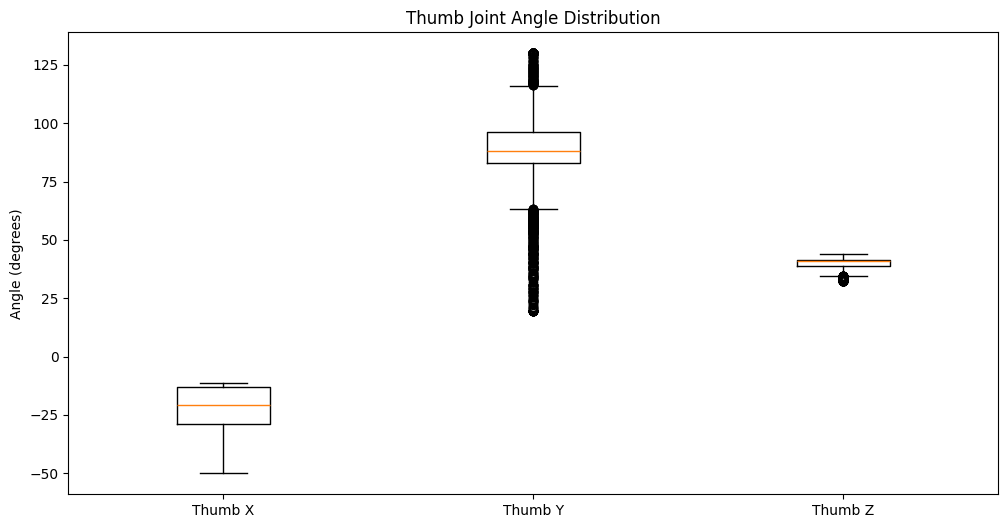

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.boxplot(joint_angles[:, :3], labels=['Thumb X', 'Thumb Y', 'Thumb Z'])  # First 3 columns (thumb)
plt.title("Thumb Joint Angle Distribution")
plt.ylabel("Angle (degrees)")
plt.show()